In [ ]:
import json

input_file = "/Users/phoebeeeee/ongoing/Beyond-noise/2_llm_validation/500/LLM_exp+LLM_dist+LLM_validate/llama-8b/scores.json"
output_file = "/Users/phoebeeeee/ongoing/Beyond-noise/ranking/8b_ranking.json"

LABELS = ["entailment", "neutral", "contradiction"]
LABEL_SHORT = {"entailment": "e", "neutral": "n", "contradiction": "c"}

def compute_rank_by_amount(count_dict, use_short=True):
    counts = {}
    if use_short:
        for label in ["e", "n", "c"]:
            counts[label] = count_dict.get(label, 0) or 0
    else:
        for label in LABELS:
            key = LABEL_SHORT[label]
            value = count_dict.get(label, 0)
            counts[key] = value if value is not None else 0

    sorted_items = sorted(counts.items(), key=lambda x: (-x[1], x[0]))

    ranks = {}
    current_rank = 1
    previous_count = None

    for i, (label, count) in enumerate(sorted_items):
        if i == 0:
            rank = current_rank
        else:
            if count == previous_count:
                rank = current_rank
            else:
                current_rank += 1
                rank = current_rank
        ranks[label] = rank
        previous_count = count

    return ranks

data = []
with open(input_file, "r", encoding="utf-8") as f:
    for i, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue
        try:
            item = json.loads(line)
        except json.JSONDecodeError as e:
            print(f"❌ JSONDecodeError on line {i}: {e}")
            print(f"Line content: {line}")
            break

        r1_counts = item.get("label_count_round_1", {})
        r2_counts = item.get("label_count_round_2", {})
        # chaosnli_counts = item.get("chaosnli_labels", {})

        item["ranking_round_1"] = compute_rank_by_amount(r1_counts)
        item["ranking_round_2"] = compute_rank_by_amount(r2_counts)
        # item["ranking_chaosnli"] = compute_rank_by_amount(chaosnli_counts, use_short=True)

        data.append(item)

with open(output_file, "w", encoding="utf-8") as f:
    for item in data:
        f.write(json.dumps(item, ensure_ascii=False) + "\n")


JSONDecodeError: Expecting property name enclosed in double quotes: line 2 column 1 (char 2)

{"id": "1735n", "context": "that doesn't seem fair does it", "statement": "That might possibly be fair.", "entailment": [], "neutral": [{"annotator": 1, "id": "1474-neutral-1", "judgments": [{"annotator": 0, "makes_sense": true}, {"annotator": 1, "makes_sense": false}, {"annotator": 2, "makes_sense": true}, {"annotator": 3, "makes_sense": true}], "label_correction": false, "reason": "The context can be interpreted as saying that it seems unfair but that this maybe wouldn't hold under closer inspection. In that case it doesn't really say something about the actual fairness.", "self_corrected": true}], "contradiction": [{"annotator": 0, "id": "1474-contradiction-1", "judgments": [{"annotator": 0, "makes_sense": true}, {"annotator": 1, "makes_sense": true}, {"annotator": 2, "makes_sense": true}, {"annotator": 3, "makes_sense": false}], "label_correction": false, "reason": "The context suggests that this may not be fair, while the statement suggests that it may be fair.", "self_corrected": false}, {"annotator": 1, "id": "1474-contradiction-2", "judgments": [{"annotator": 0, "makes_sense": true}, {"annotator": 1, "makes_sense": true}, {"annotator": 2, "makes_sense": true}, {"annotator": 3, "makes_sense": true}], "label_correction": false, "reason": "The context can be interpreted as saying that it's really not fair, so it cannot be possibly fair.", "self_corrected": false}, {"annotator": 2, "id": "1474-contradiction-3", "judgments": [{"annotator": 0, "makes_sense": true}, {"annotator": 1, "makes_sense": true}, {"annotator": 2, "makes_sense": true}, {"annotator": 3, "makes_sense": false}], "label_correction": false, "reason": "The context suggests a higher possibility of unfairness in this matter, which the statement does not reflect.", "self_corrected": false}, {"annotator": 3, "id": "1474-contradiction-4", "judgments": [{"annotator": 0, "makes_sense": true}, {"annotator": 1, "makes_sense": true}, {"annotator": 2, "makes_sense": true}, {"annotator": 3, "makes_sense": true}], "label_correction": false, "reason": "It's a rhetorical question. The speaker means it's not fair", "self_corrected": false}], "idk": [], "label_count_round_1": {"contradiction": 4.0, "entailment": null, "neutral": 1.0}, "label_count_round_2": {"contradiction": 4.0, "entailment": null, "neutral": null}, "label_set_round_1": ["neutral", "contradiction"], "label_set_round_2": ["contradiction"], "error_labels": ["neutral"], "has_ambiguity": false, "chaosnli_labels": {"c": 48, "n": 31, "e": 21}, "ranking_round_1": {"c": 1, "n": 2, "e": 3}, "ranking_round_2": {"c": 1, "e": 2, "n": 2}, "ranking_chaosnli": {"c": 1, "n": 2, "e": 3}}


In [17]:
## llm vs. chaosnli

import json
import pandas as pd
from scipy.stats import kendalltau

file1 = "/Users/phoebeeeee/ongoing/Beyond-noise/ranking/gpt_ranking.json"
file2 = "/Users/phoebeeeee/ongoing/Beyond-noise/ranking/varierr_ranking.json"

LABEL_MAP = {
    "entailment": "e",
    "contradiction": "c",
    "neutral": "n",
    "e": "e",
    "n": "n",
    "c": "c"
}

def load_llm_rankings(filepath):
    data = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line)
            id_ = item.get("id")
            if not id_:
                continue
            r1 = {LABEL_MAP.get(k, k): v for k, v in item.get("ranking_round_1", {}).items()}
            # r2 = {LABEL_MAP.get(k, k): v for k, v in item.get("ranking_round_2", {}).items()}
            # data[id_] = {"round_1": r1, "round_2": r2}
            data[id_] = {"round_1": r1}
    return data

def load_chaosnli_rankings(filepath):
    data = {}
    with open(filepath, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line)
            id_ = item.get("id")
            if not id_:
                continue
            chaos_rank = {LABEL_MAP.get(k, k): v for k, v in item.get("ranking_round_1", {}).items()}
            data[id_] = chaos_rank
    return data

def compute_tau(vec1, vec2):
    if len(vec1) != len(vec2) or len(vec1) < 2:
        return None
    tau, _ = kendalltau(vec1, vec2)
    return tau

llm_rankings = load_llm_rankings(file1)
chaosnli_rankings = load_chaosnli_rankings(file2)

results = []

for id_ in sorted(set(llm_rankings) & set(chaosnli_rankings)):
    chaos = chaosnli_rankings[id_]
    # for round_name in ["round_1", "round_2"]:
    for round_name in ["round_1"]:
        llm_rank = llm_rankings[id_].get(round_name, {})

        desired_order = ['e', 'n', 'c']
        common_keys = [k for k in desired_order if k in llm_rank and k in chaos]
        if len(common_keys) < 2:
            continue

        llm_vec = [llm_rank[k] for k in common_keys]
        chaos_vec = [chaos[k] for k in common_keys]

        tau = compute_tau(llm_vec, chaos_vec)

        results.append({
            "id": id_,
            "round": round_name,
            "labels": ",".join(common_keys),
            "llm_ranks": llm_vec,
            "chaosnli_ranks": chaos_vec,
            "kendall_tau": tau
        })
# 保存结果为 CSV
df = pd.DataFrame(results)
df.to_csv("kendall_tau_gpt_vs_varierr_before.csv", index=False)

print("✅ Done! Avg Kendall’s Tau:", df["kendall_tau"].mean())


✅ Done! Avg Kendall’s Tau: 0.2375522974473755


In [ ]:
# spearman
import csv
from scipy.stats import spearmanr


# LABEL_MAP = {
#     "entailment": "e",
#     "neutral": "n",
#     "contradiction": "c",
#     "e": "e",
#     "n": "n",
#     "c": "c",
# }

file_a = "/Users/phoebeeeee/ongoing/Beyond-noise/ranking/llama_ranking_deduplication.json"
file_b = "/Users/phoebeeeee/ongoing/Beyond-noise/ranking/varierr_ranking.json"


def load_rankings(file_path):
    data = {}
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            item = json.loads(line)
            id_ = item["id"]
            d = {}
            for key in ["ranking_round_1", "ranking_round_2"]:
                if key in item:
                    d[key] = {k: v for k, v in item[key].items()}
            data[id_] = d
    return data

data_a = load_rankings(file_a)
data_b = load_rankings(file_b)

results = []

for id_ in sorted(set(data_a.keys()) & set(data_b.keys())):
    r1_a = data_a[id_].get("ranking_round_1", {})
    r1_b = data_b[id_].get("ranking_round_1", {})
    r2_a = data_a[id_].get("ranking_round_2", {})
    r2_b = data_b[id_].get("ranking_round_2", {})

    for round_name, ra, rb in [
        ("round_1", r1_a, r1_b),
        ("round_2", r2_a, r2_b)
    ]:
        desired_order = ['e', 'n', 'c']
        common_keys = [k for k in desired_order if k in ra and k in rb]
        if len(common_keys) < 2:
            continue

        v1 = [ra[k] for k in common_keys]
        v2 = [rb[k] for k in common_keys]

        rho, p = spearmanr(v1, v2)
        results.append({
            "id": id_,
            "round": round_name,
            "common_labels": common_keys,
            "spearman_rho": rho,
            "p_value": p,
        })

output_tsv = "spearman_ranking_comparison.tsv"
with open(output_tsv, "w", encoding="utf-8", newline="") as f:
    writer = csv.DictWriter(f, fieldnames=["id", "round", "labels", "llm_ranks", "human_ranks", "spearman"], delimiter="\t")
    writer.writeheader()
    for r in results:
        if r["spearman_rho"] is None:
            continue
        writer.writerow({
            "id": r["id"],
            "round": r["round"],
            "labels": ",".join(r["common_labels"]),
            "llm_ranks": ",".join(str(data_a[r["id"]][f"ranking_{r['round']}"][k]) for k in r["common_labels"]),
            "human_ranks": ",".join(str(data_b[r["id"]][f"ranking_{r['round']}"][k]) for k in r["common_labels"]),
            "spearman": f"{r['spearman_rho']:.4f}"
        })

print(f"📄 Spearman comparison saved to {output_tsv}")


if results:
    rhos = [r["spearman_rho"] for r in results if r["spearman_rho"] is not None]
    print(f"✅ In total {len(results)} items，avg spearman：{sum(rhos)/len(rhos):.3f}")
else:
    print("⚠️ No comparable samples found")



/var/folders/m4/bdfxxbj17j90t407ws9bzdrm0000gn/T/ipykernel_35716/3151685099.py:57: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  rho, p = spearmanr(v1, v2)


📄 Spearman comparison saved to spearman_ranking_comparison.tsv
✅ 总共比较 682 项，有效 Spearman 平均值：nan


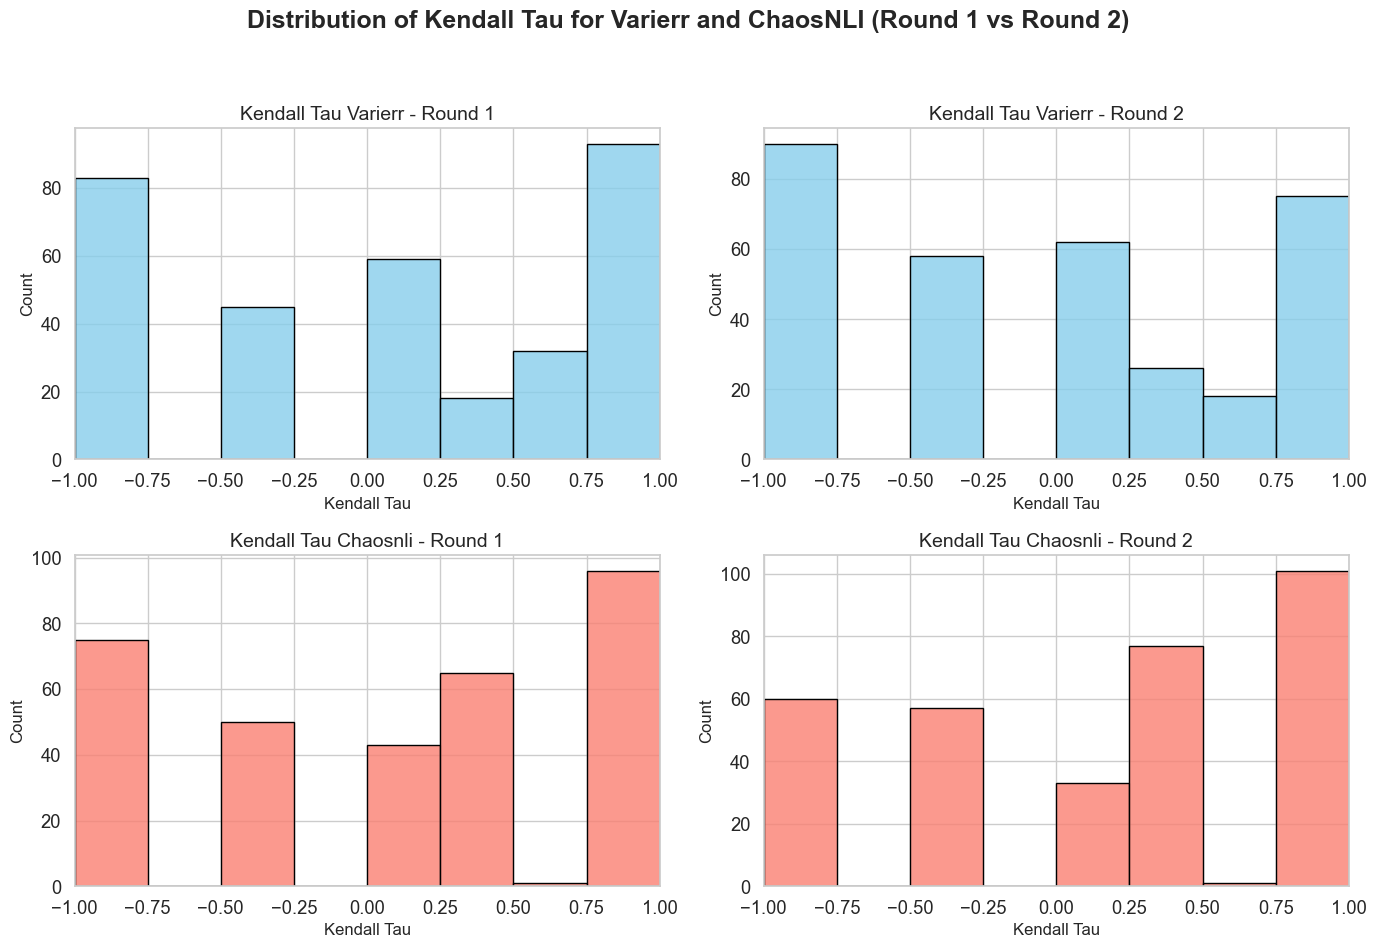

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = '/Users/phoebeeeee/ongoing/Beyond-noise/ranking/kendall_tau_varierr_chaosnli.csv'
df = pd.read_csv(file_path)

df_round1 = df[df['round'].isin(['round_1', 'round1'])].copy()
df_round2 = df[df['round'].isin(['round_2', 'round2'])].copy()

for col in ['kendall_tau_varierr', 'kendall_tau_chaosnli']:
    df_round1[col] = pd.to_numeric(df_round1[col], errors='coerce')
    df_round2[col] = pd.to_numeric(df_round2[col], errors='coerce')

df_round1 = df_round1.dropna(subset=['kendall_tau_varierr', 'kendall_tau_chaosnli'])
df_round2 = df_round2.dropna(subset=['kendall_tau_varierr', 'kendall_tau_chaosnli'])

cols_to_plot = ['kendall_tau_varierr', 'kendall_tau_chaosnli']
colors = ['skyblue', 'salmon']
bins = np.linspace(-1, 1, 9)

sns.set(style="whitegrid", font_scale=1.2)
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Distribution of Kendall Tau for Varierr and ChaosNLI (Round 1 vs Round 2)', fontsize=18, weight='bold')

for i, col in enumerate(cols_to_plot):
    # Round 1
    sns.histplot(df_round1[col], bins=bins, ax=axs[i][0], color=colors[i], edgecolor='black', alpha=0.8)
    axs[i][0].set_title(f'{col.replace("_", " ").title()} - Round 1', fontsize=14)
    axs[i][0].set_xlabel('Kendall Tau', fontsize=12)
    axs[i][0].set_ylabel('Count', fontsize=12)
    axs[i][0].set_xlim(-1, 1)

    # Round 2
    sns.histplot(df_round2[col], bins=bins, ax=axs[i][1], color=colors[i], edgecolor='black', alpha=0.8)
    axs[i][1].set_title(f'{col.replace("_", " ").title()} - Round 2', fontsize=14)
    axs[i][1].set_xlabel('Kendall Tau', fontsize=12)
    axs[i][1].set_ylabel('Count', fontsize=12)
    axs[i][1].set_xlim(-1, 1)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

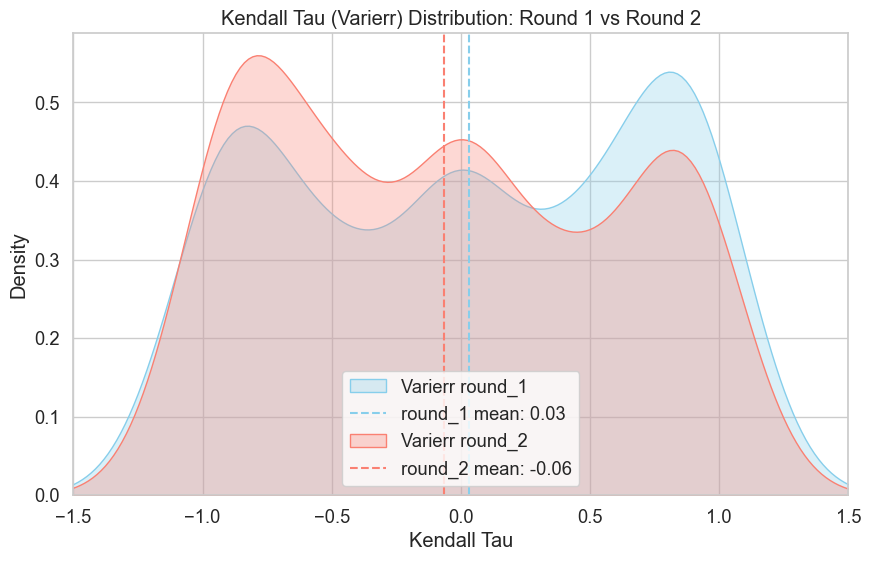

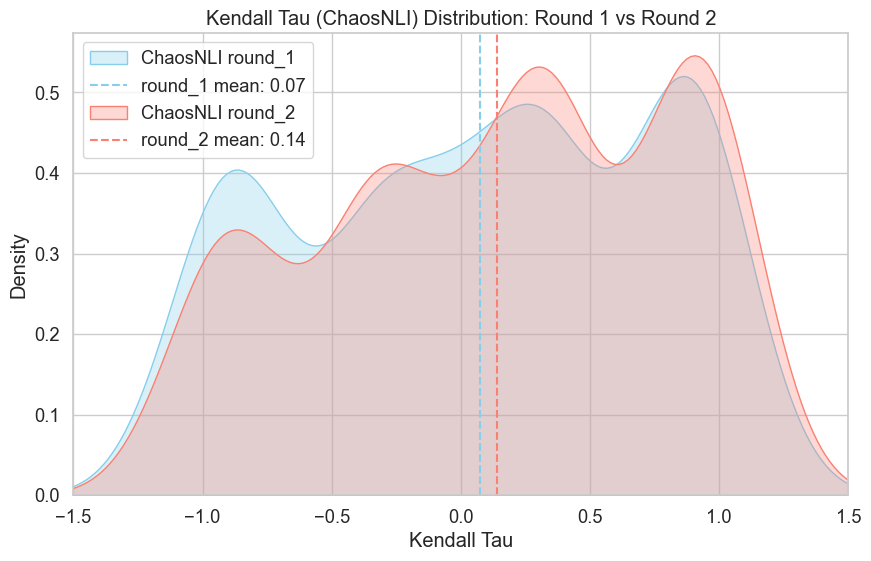

In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

file_path = '/Users/phoebeeeee/ongoing/Beyond-noise/ranking/kendall_tau_varierr_chaosnli.csv'
df = pd.read_csv(file_path)

for col in ['kendall_tau_varierr', 'kendall_tau_chaosnli']:
    df[col] = pd.to_numeric(df[col], errors='coerce')

df = df.dropna(subset=['kendall_tau_varierr', 'kendall_tau_chaosnli', 'round'])

plt.figure(figsize=(10, 6))
for round_name, color in zip(['round_1', 'round_2'], ['skyblue', 'salmon']):
    subset = df[df['round'].isin([round_name, round_name.replace('_', '')])]
    sns.kdeplot(subset['kendall_tau_varierr'], label=f'Varierr {round_name}', color=color, fill=True, alpha=0.3)
    mean = subset['kendall_tau_varierr'].mean()
    plt.axvline(mean, color=color, linestyle='--', label=f'{round_name} mean: {mean:.2f}')

plt.title('Kendall Tau (Varierr) Distribution: Round 1 vs Round 2')
plt.xlabel('Kendall Tau')
plt.ylabel('Density')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()


plt.figure(figsize=(10, 6))
for round_name, color in zip(['round_1', 'round_2'], ['skyblue', 'salmon']):
    subset = df[df['round'].isin([round_name, round_name.replace('_', '')])]
    sns.kdeplot(subset['kendall_tau_chaosnli'], label=f'ChaosNLI {round_name}', color=color, fill=True, alpha=0.3)
    mean = subset['kendall_tau_chaosnli'].mean()
    plt.axvline(mean, color=color, linestyle='--', label=f'{round_name} mean: {mean:.2f}')

plt.title('Kendall Tau (ChaosNLI) Distribution: Round 1 vs Round 2')
plt.xlabel('Kendall Tau')
plt.ylabel('Density')
plt.xlim(-1.5, 1.5)
plt.legend()
plt.show()